In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)
engine.dispose()

In [4]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [5]:
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street", drop_first=True).columns)

In [6]:
Y = df['saleprice']
# X is the feature set
X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

model = sm.OLS(y_train, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:08:25   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We have a good R**2.

The following explanatory variables are not statistcally significant:
    * garagearea
    * mszoning_FV
    * mszoning_RH
    * mszoning_RM
    * mszoning_RL
    * street_Pave


We should check to see if the dist of residuals are normal to see if we can trust these results.

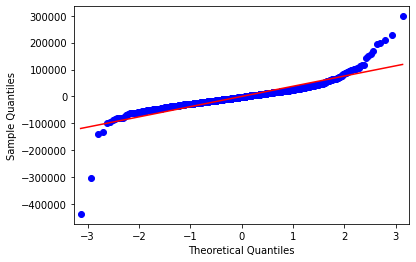

In [7]:
sm.qqplot(model.resid, line="s")
plt.show()

Not very normal, we could try to log transform target variable (Saleprice) but we wont yet.

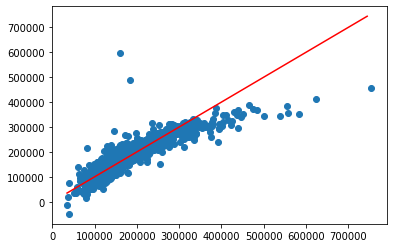

In [8]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

plt.scatter(y_train, y_pred_train)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='red')

This is okay, not great we could improve.

In [9]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,2,2008,WD,Normal,208500,0,0,1,0,1
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,5,2007,WD,Normal,181500,0,0,1,0,1
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,9,2008,WD,Normal,223500,0,0,1,0,1
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,2,2006,WD,Abnorml,140000,0,0,1,0,1
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,12,2008,WD,Normal,250000,0,0,1,0,1


In [12]:
print_vif(X_train)

VIF results
-------------------------------
const                248.908
overallqual            2.066
grlivarea              1.674
totalbsmtsf            1.580
mszoning_RH            1.018
mszoning_RM            1.093
street_Pave            1.025
garage_interaction     1.784
dtype: float64
-------------------------------



In [11]:
X['garage_interaction']=X['garagecars']*X['garagearea']
X=X.drop(columns=['mszoning_FV', 'mszoning_RL', 'garagearea', 'garagecars'])

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

model = sm.OLS(y_train, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     575.9
Date:                Wed, 09 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:08:26   Log-Likelihood:                -13950.
No. Observations:                1168   AIC:                         2.792e+04
Df Residuals:                    1160   BIC:                         2.796e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.964e+04   1.72e+04     -4.618      0.000   -1.13e+05   -4.58e+04
overallqual         2.406e+04   1148.530     20.946      0.000    2.18e+04    2.63e+04
grlivarea             41.1310      2.689     15.297      0.000      35.855      46.407
totalbsmtsf           20.2618      3.055      6.633      0.000      14.268      26.256
mszoning_RH        -1.987e+04   1.01e+04     -1.961      0.050   -3.98e+04       8.791
mszoning_RM        -2.156e+04   3209.074     -6.719      0.000   -2.79e+04   -1.53e+04
street_Pave         9712.9945    1.7e+04      0.573      0.567   -2.35e+04     4.3e+04
garage_interaction    24.0542      2.037     11.811      0.000      20.058      28.050
==============================================================================
Omnibus:                      388.327   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33362.716
Skew:                          -0.557   Prob(JB):                         0.00
Kurtosis:                      29.159   Cond. No.                     4.87e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

By dropping some of the zoning variables and by adding an interaction vairable for the garage var